# Vehicle Detection and Tracking

THe goal of this project is to write a software pipeline to detect vehicles in a video

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from scipy.ndimage.measurements import label

%matplotlib inline

## Helper Functions from the Lesson

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image
def single_img_features(img, color_space='RGB2YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != None:        
        feature_image = convert_color(img, color_space)
    else:
        feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB2YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # OpenCV reads an image as BGR, so converting it to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        image = image.astype(np.float32)/255
        features.append(single_img_features(image))        
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    #imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return img
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, xstop, ystart, ystop, scale, 
              svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox_list = []
    draw_img = np.copy(img)
    if np.max(img) > 1.0:
        img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left+xstart, ytop_draw+ystart), (xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(bbox)
                #cv2.rectangle(draw_img, bbox[0], bbox[1],(0,0,255),6) 
                
    return bbox_list

def add_heat(heatmap, bboxes_history):
    for bbox_list in bboxes_history:
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Training

Total Number of Car Images: 8792
Total Number of Non-Car Images: 8968
Loading Pre Trained SVC..
Loading Scaler..
Using: 9 orientations 8 pixels per cell and 2 cells per block


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


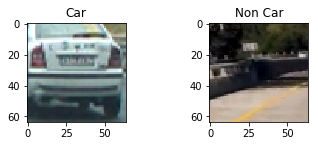

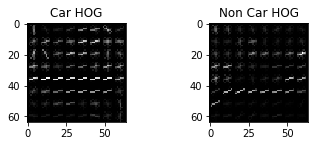

In [3]:
import time
import pickle
import os.path
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Read in cars and notcars
#car_images = glob.glob('.\\data\\vehicles_smallset\\*.jpeg')
#non_car_images = glob.glob('.\\data\\non-vehicles_smallset\\*.jpeg')

car_images = glob.glob('.\\data\\vehicles\\*\\*.png')
non_car_images = glob.glob('.\\data\\non-vehicles\\*\\*.png')

print('Total Number of Car Images: {}'.format(len(car_images)))
print('Total Number of Non-Car Images: {}'.format(len(non_car_images)))

# Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

if os.path.isfile("svc.p"):
    print("Loading Pre Trained SVC..")
    with open("svc.p", "rb") as f:
        svc = pickle.load(f)
    print("Loading Scaler..")
    with open("x_scaler.p", "rb") as f:
        X_scaler = pickle.load(f)
else:    
    if os.path.isfile("car_features.p"):
        print("Loading Precalculated Car Features..")
        with open("car_features.p", "rb") as f:
            car_features = pickle.load(f)        
    else:
        car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        with open('car_features.p', 'wb') as f:
            pickle.dump(car_features, f)

    if os.path.isfile("notcar_features.p"):
        print("Loading Precalculated Non-Car Features..")
        with open("notcar_features.p", "rb") as f:
            notcar_features = pickle.load(f)
    else:
        notcar_features = extract_features(non_car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        with open('notcar_features.p', 'wb') as f:
            pickle.dump(notcar_features, f)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    
    if os.path.isfile("x_scaler.p"):
        with open('x_scaler.p', 'rb') as f:
            X_scaler = pickle.load(f)
    else:
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        print("Storing Scaler")
        with open('x_scaler.p', 'wb') as f:
            pickle.dump(X_scaler, f)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    print("Storing SVC Model Data")
    with open('svc.p', 'wb') as f:
        pickle.dump(svc, f)  

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')

# Pick a Random Image of a Car and Not-Car from the dataset and plot it
rand_car = cv2.imread(car_images[2700])
rand_car = cv2.cvtColor(rand_car, cv2.COLOR_BGR2RGB)
rand_not_car = cv2.imread(non_car_images[2700])
rand_not_car = cv2.cvtColor(rand_not_car, cv2.COLOR_BGR2RGB)

fig = plt.figure()    
plt.subplot(221)
plt.imshow(rand_car)
plt.title('Car')
plt.subplot(222)
plt.imshow(rand_not_car)
plt.title('Non Car')

# Convert to YCrCb color space
rand_car = convert_color(rand_car)
rand_not_car = convert_color(rand_not_car)
# Get HOG features for Channel 0
rand_car_hog_features, rand_car_hog_img = get_hog_features(rand_car[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
rand_not_car_hog_features, rand_not_car_hog_img = get_hog_features(rand_not_car[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
fig = plt.figure()
plt.subplot(221)
plt.imshow(rand_car_hog_img, cmap='gray')
plt.title('Car HOG')
plt.subplot(222)
plt.imshow(rand_not_car_hog_img, cmap='gray')
plt.title('Non Car HOG')


## Vehicle Detection Pipeline

In [4]:
x_start = 280
x_stop = 1280
y_start = 380 
y_stop = 656
scale = 1.5

'''
Processing Pipeline
'''
bboxes_history = []
def process(frame, heat_threshold):
    bbox_list = find_cars(frame, x_start, x_stop, y_start, y_stop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    
    # Retain bboxes found for previous 4 frames
    bboxes_history.append(bbox_list)
    if len(bboxes_history) > 8:
        del bboxes_history[0]
        
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes_history)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    output = draw_labeled_bboxes(np.copy(frame), labels)
    # Area being scanned for cars
    # cv2.rectangle(output, (x_start, y_start), (x_stop, y_stop), (255, 0, 0), 2)
    return output, heatmap

## Process Test Images

Run the pipeline on provided test images

C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


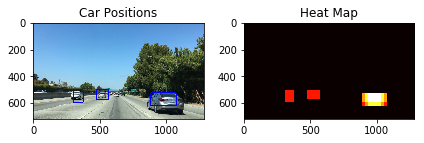

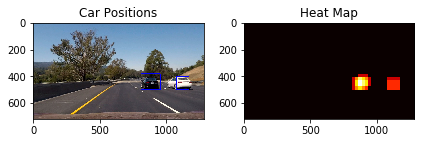

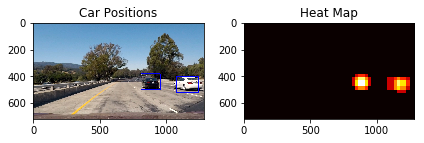

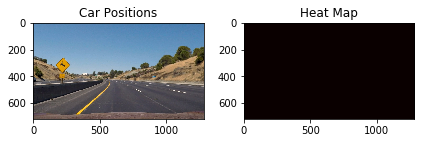

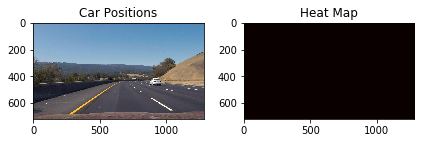

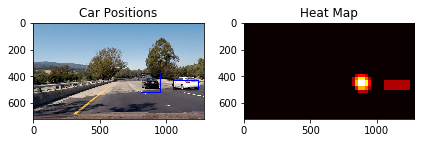

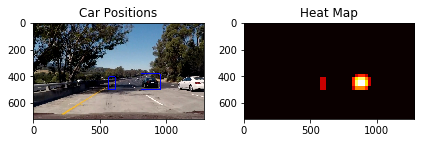

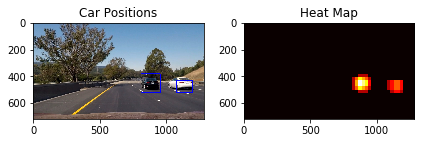

In [5]:
#image = cv2.imread('bbox-example-image.jpg')
test_images = glob.glob('.\\test_images\\*.jpg')
for img_path in test_images:
    img_name = img_path.split('\\')[2]
    image = cv2.imread(img_path)
    #
    # OpenCV Reads Image as BGR, convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Clear boxes history, this is useful for video processing only
    del bboxes_history[:]
    result, heatmap = process(image, heat_threshold=1)
    to_save = convert_color(result, 'RGB2BGR')
    cv2.imwrite('.\\output_images\\{}'.format(img_name), to_save)
    
    fig = plt.figure()    
    plt.subplot(121)
    plt.imshow(result)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

## Process Project Video

Run the pipeline on provided project video

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

if not os.path.exists("output_videos"):
    os.makedirs("output_videos")
    
if not os.path.exists("video_frames"):
    os.makedirs("video_frames")

In [7]:
frame_idx = 1
def process_frame(frame):
    global frame_idx
    output, heatmap = process(frame, heat_threshold=2)
    #blank = np.zeros_like(heatmap)
    #heatmap = heatmap * 10.0
    #heatmap_frame = np.dstack((blank, blank, heatmap))
    #img = convert_color(frame, 'RGB2BGR')    
    #cv2.imwrite('.\\video_frames\\heatmap_{}.jpg'.format(frame_idx), heatmap_frame)
    #cv2.imwrite('.\\video_frames\\output_{}.jpg'.format(frame_idx),  convert_color(output, 'RGB2BGR'))
    frame_idx += 1
    return output

# Clear boxes history before processing each video
del bboxes_history[:]
#video_file = "test_video.mp4"
video_file = "test_video.mp4"
project_video_out = 'output_videos/' + video_file
#clip1 = VideoFileClip("test_video.mp4").subclip(20,28)
#clip1 = VideoFileClip(video_file).subclip(25, 45)
clip1 = VideoFileClip(video_file)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(project_video_out, audio=False)
del clip1

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:16<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

Wall time: 17.8 s
